# Crew Recommendation Model

The objective of this notebook is build a Machine Learning model to predict the crew size during the design process of a ship

## Importing the libraries

In [273]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit

# from statsmodels.regression.linear_model import OLS
# from statsmodels.tools import add_constant
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import display

%matplotlib inline
sns.set_style('whitegrid')

## Reading the dataset from the CSV file

In [2]:
ships = pd.read_csv('Barcos.csv')

## Exploratory Data Analysis (EDA)

### Structure and overall information of the dataset

In [3]:
ships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Nombre de la Embarcacion  158 non-null    object 
 1   Naviera                   158 non-null    object 
 2   Edad                      158 non-null    int64  
 3   Tonelaje                  158 non-null    float64
 4   Pasajeros                 158 non-null    float64
 5   Longitud                  158 non-null    float64
 6   Camarotes                 158 non-null    float64
 7   Densidad de Pasajeros     158 non-null    float64
 8   Tripulacion               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


The dataset has 9 columns and 158 rows with 0 null values. two of the columns are object, one int and the reset of them are float

In [4]:
ships.head()

,Nombre de la Embarcacion,Naviera,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


From this subset is clear that:
 - columns "Nombre de la Embarcacion" and "Naviera" are categorical variables 
 - "Edad", "Tonelaje", "Pasajeros", "Longitud", "Camarotes" and "Densidad de Pasajeros" are numerical variables
 - "Tripulacion" which is the dependant variable  is also numeric

### Analyzing categorical variables

#### Ship name

In [5]:
ship_name_counts = ships['Nombre de la Embarcacion'].value_counts()
display(ship_name_counts.to_frame())
(
    ship_name_counts
    .value_counts()
    .sort_values(ascending=True)
    .rename_axis('Ships With Same Name')
    .reset_index(name='Counts')
)

,Nombre de la Embarcacion
Spirit,4
Legend,3
Star,3
Wind,2
Jewel,2
...,...
Explorer,1
MarcoPolo,1
Conquest,1
Nautica,1


,Ships With Same Name,Counts
0,4,1
1,3,2
2,2,13
3,1,122


There are 138 unique names, this means that some names can be repeated but not in a rate that can represent an estimator

In [6]:
ships[ships['Nombre de la Embarcacion'] == 'Spirit']

,Nombre de la Embarcacion,Naviera,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
20,Spirit,Carnival,12,88.500,21.24,9.63,10.56,41.67,10.29
83,Spirit,Norwegian,15,75.338,19.56,8.79,9.83,38.52,13.00
144,Spirit,Seabourn,24,10.000,2.08,4.40,1.04,48.08,1.60
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88


for example the most popular name is "Spirit" but the caracteristics of the ships are totally different

#### Company

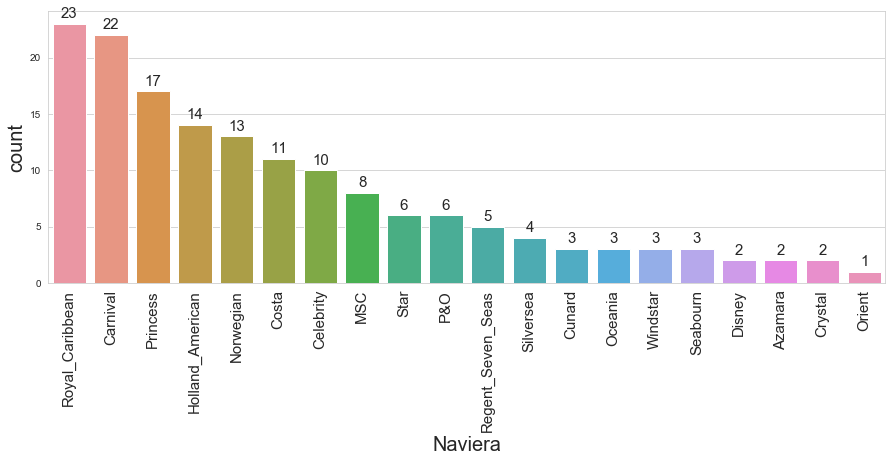

In [7]:
naviera_counts = ships['Naviera'].value_counts()

plt.figure(figsize=(15, 5))
graph = sns.countplot(x='Naviera', data=ships, order=naviera_counts.index)
graph.xaxis.set_tick_params(rotation=90, labelsize=15)
graph.xaxis.get_label().set_fontsize(20)
graph.yaxis.get_label().set_fontsize(20)
for p in graph.patches:
    graph.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 10),
        textcoords = 'offset points',
        size=15
    )

From this instance is observed that there are 20 different companies, the biggest is Royal_Caribbean with 23 ships and the smallest is Orient with 1

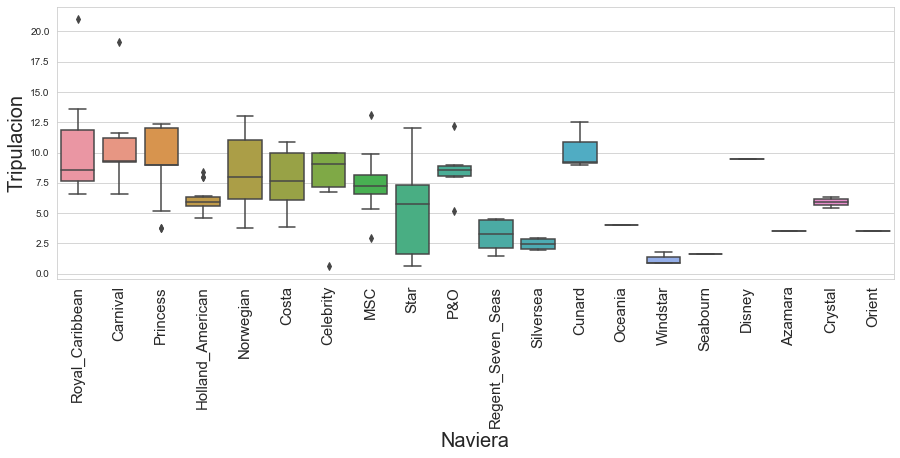

In [8]:
plt.figure(figsize=(15, 5))
graph = sns.boxplot(
    x='Naviera',
    y='Tripulacion',
    data=ships,
    order=naviera_counts.index)
graph.xaxis.set_tick_params(rotation=90, labelsize=15)
graph.xaxis.get_label().set_fontsize(20)
graph.yaxis.get_label().set_fontsize(20)


From the box plot is difficult to see a clear relationship between the company and the crew number, eventhough in some cases like Holland_American seems to have the crew of their ships in the same range. Nevertheless, there are companies with very few ships so including this variable could lead us to overfit our model and besides the model would perform poorly to predict data for a non included company 

### Analizing numerical variables

In [9]:
ships.describe()

,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


There are two important observations from this table
 - First, the data has different scale of values, for example, the maximum value of Tonnage is 220 while the max value of Longitud is 11.82.
 - Second, crew has a mean of 7.79 with a std of 3.5 and a value in 75 percentile of 9.9. However, its max value is 21 which can lead to think in outliers

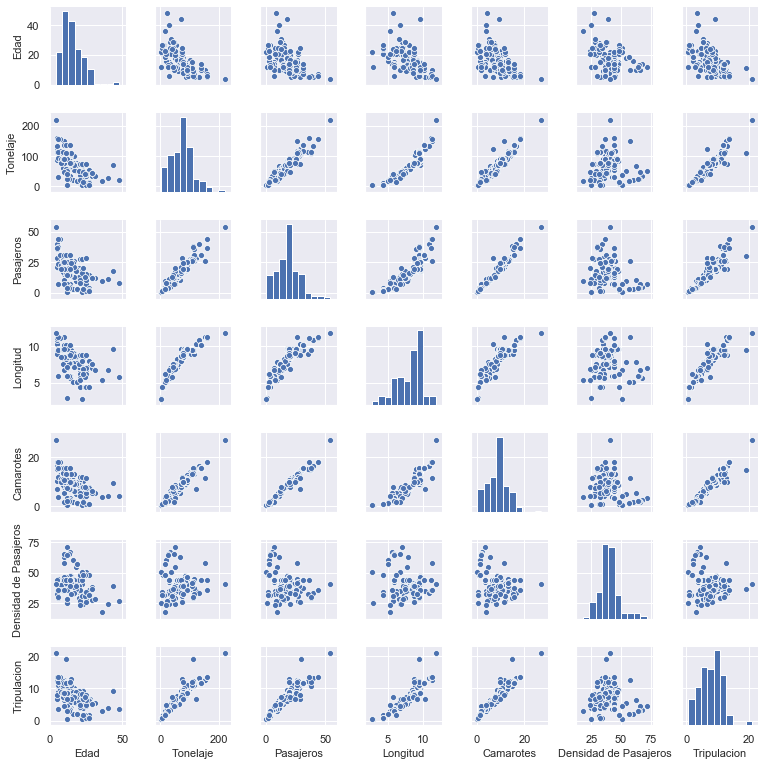

In [10]:
sns.set(rc={'axes.labelsize':'11'})
graph = sns.pairplot(ships, height=1.5)

These sort of graphs reveal a lot of information.
 - variables age and passanger density seem to be bad predictors for crew. In the other hand, tonnage, passangers, lenght and cabins have significant correlation .
 - two observations have unusual crew values
 - the relationship between the variables tonnage, passangers, lenght and cabins show a possible multicollinearity

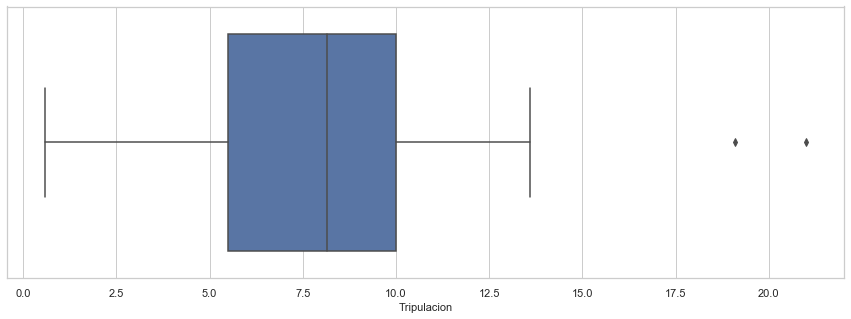

In [85]:
plt.figure(figsize=(15, 5))
sns.boxplot(ships['Tripulacion'])
plt.show()

Given that two observations have unusually high crew values they are considered as outliers and therefor remmoved from the dataset 

In [ ]:
ships_cleaned = ships[ships['Tripulacion'] < 18]

In [232]:
#ships_cleaned['Longitud2'] = np.sqrt(np.max(ships_cleaned['Longitud'] + 1) - ships_cleaned['Longitud'])

In [233]:
# fig, ax = plt.subplots(1,3, figsize=(15,5))
# sns.distplot(ships_cleaned['Longitud'], ax=ax[0])
# sns.distplot(ships_cleaned['Longitud2'], ax=ax[1])

## Variable Selection

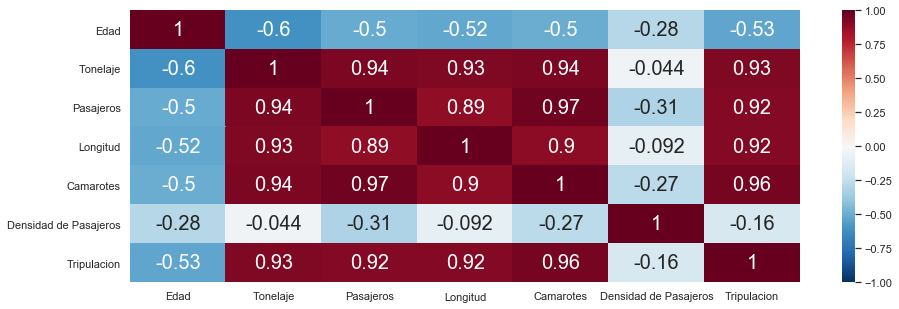

In [234]:
plt.figure(figsize=(15, 5))
graph = sns.heatmap(
    ships_cleaned.corr(),
    annot=True,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    annot_kws={'size': 20}
)

The correlation graph shows that cabins is the most high correlated variable with **crew** but **tonnage**, **passangers**, **lenght** are good predictors too.

Another point to keep in mind is that these variables are correlated amonng them too

## Dividing the dataset into training and set

In [275]:
def scale_and_split_data(
    df, sel_cols, target_var='Tripulacion', test_size=0.4, random_state=101):
    '''Scale the data using standard scaler
        
    Args: 
        df: data frame with the information
        sel_cols: List of selected independant variables
        test_size: Float of the desired test size proportion in percentage
        random_state: int to keep seed
            
    Returns:
        scaler: Scaler object fitted with the selected independant variables
        X_train: Data frame with the subset of features to train
        X_test: Data frame with the subset of features to test
        y_train: Series with the subset of the target variable to train
        y_test: Series with the subset of the target variable to test
        
    '''
    y = df[target_var]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(df[sel_cols]), columns=sel_cols)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size , random_state=random_state)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return scaler, X, y, X_train, X_test, y_train, y_test

In [276]:
sel_cols = [
    'Tonelaje',
    'Pasajeros',
    'Longitud',
    'Camarotes',
]
scaler, X, y, X_train, X_test, y_train, y_test = scale_and_split_data(
    ships_cleaned, sel_cols)
print('Train_size: ', X_train.shape[0], ' Test_size:', X_test.shape[0])

Train_size:  93  Test_size: 63


## Linear regression model

In [246]:
regr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Tripulacion   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     453.3
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           8.18e-58
Time:                        00:09:06   Log-Likelihood:                -95.769
No. Observations:                  93   AIC:                             201.5
Df Residuals:                      88   BIC:                             214.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5890      0.073    103.706      0.000       7.444       7.734
Tonelaje       0.7022      0.261      2.692      0.009       0.184       1.221
Pasajeros     -1.0547      0.421     -2.504      0.014      -1.892      -0.218
Longitud       0.7754      0.198      3.910      0.000       0.381       1.170
Camarotes      2.7075      0.443      6.113      0.000       1.827       3.588
==============================================================================
Omnibus:                        1.910   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.449
Skew:                          -0.095   Prob(JB):                        0.485
Kurtosis:                       2.419   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the model summary is important to focus on the following points:
- The model has a $R^2$ of 0.954 which is good and the $adjR^2$ of 0.952 is very similar
- All the variables are significant for the model given that all of them have a p_value below 0.05
- The most significant coefficient is cabins

In [247]:
y_train_pred = regr.predict(sm.add_constant(X_train))
y_test_pred = regr.predict(sm.add_constant(X_test))

### Testing of Assiumptions

#### Linearity of the model

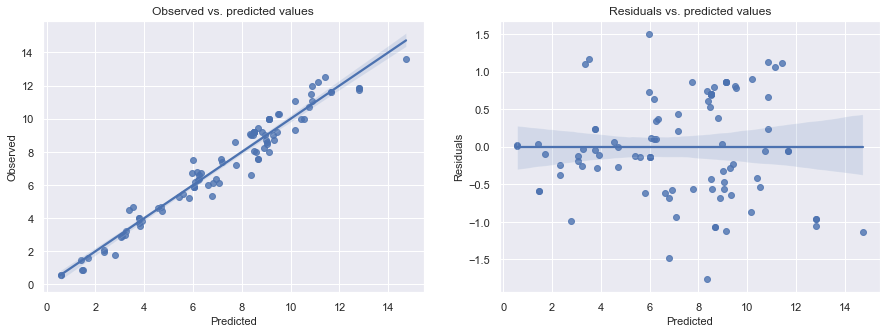

In [257]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.regplot(x=y_train_pred, y=y_train, ax=ax[0])
ax[0].set_title('Observed vs. predicted values')
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=y_train_pred, y=regr.resid, ax=ax[1])
ax[1].set_title('Residuals vs. predicted values')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

plt.show()

The outcomes of the Observed vs. predicted values are symmetrically distributed around the diagonal and is the same for the Residuals vs. Predicted values against the horizontal line. In addition, both graphs shows a constant variance.
This means that there is indeed a linear relationship among variables.

#### Mean of residuals equal to zero

In [249]:
regr.resid.mean()

-2.597683119983162e-15

The mean of the residuals is indeed very close to zero

#### multivariate normal

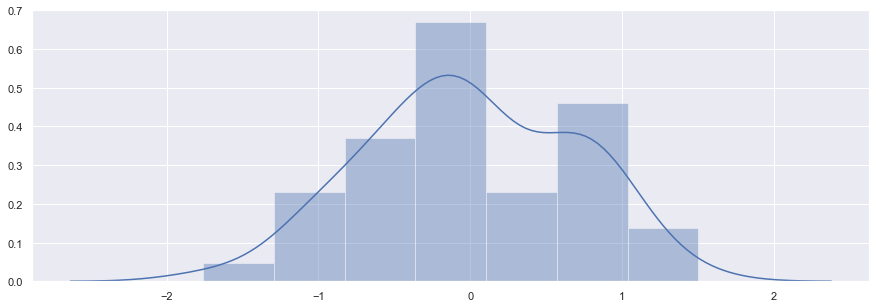

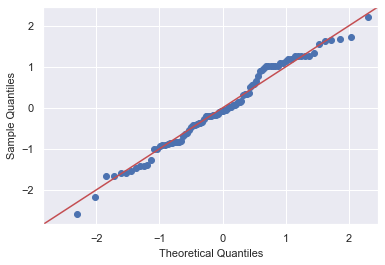

In [265]:
plt.figure(figsize=(15, 5))
sns.distplot((y_train - y_train_pred))
qqplot((y_train - y_train_pred), line='45', fit='True')
plt.show()

Residuals seems close to normality, which menas that a linear model is a good choice

#### Multicollinearity 

In [266]:
def calculate_vif(df):
    '''Calculates the variance inflation factor(VIF) and represent it as a data frame
        
    Args: 
        df: pandas data frame with the independant variables
            
    Returns:
        data frame: variables as index with the VIF value as column
    '''
    return pd.DataFrame(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index= df.columns,
        columns=['VIF']
    )

In [267]:
calculate_vif(ships_cleaned[sel_cols])

,VIF
Tonelaje,51.741901
Pasajeros,104.083364
Longitud,14.729180
Camarotes,119.972761


 All of the variables have a VIF value above 10 which means a high multicollinearity, this prevents the coeficients to have a meaningful value by their own but the model can still be a good predictor which is the main goal

### Model Evaluation

In [269]:
pd.DataFrame({
    'R^2_Train': metrics.r2_score(y_train, y_train_pred),
    'R^2_Test': metrics.r2_score(y_test, y_test_pred),
    'RSME_Train': np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)),
    'RSME_Test': np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
}, index=['Results'])

,R^2_Train,R^2_Test,RSME_Train,RSME_Test
Results,0.953714,0.91881,0.677624,0.923625


The model perform slightly better in train than in test.

### Cross Validation

In [278]:
lm = LinearRegression()
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
scores = cross_validate(
    lm, X, y,cv=cv, scoring=['r2', 'neg_root_mean_squared_error'],
    return_train_score=True)

mean_results = lambda x: np.round(np.mean(x), 3)
sd_results = lambda x: np.round(np.std(x), 3)

pd.DataFrame(
    {
        'R^2_mean': [
            mean_results(scores['train_r2']),
            mean_results(scores['test_r2'])],
        'R^2_Std':  [
            sd_results(scores['train_r2']),
            sd_results(scores['test_r2'])],
        'RSME_mean': [
            mean_results(scores['train_neg_root_mean_squared_error']*-1),
            mean_results(scores['test_neg_root_mean_squared_error']*-1)],
        'RSME_Std':[
            sd_results(scores['train_neg_root_mean_squared_error']*-1),
            sd_results(scores['test_neg_root_mean_squared_error']*-1)],
    },
    index=['Train', 'Test']
)

,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


After 10 iterations of random samples the model peforms well on both training and testing, the accuracy is a little bit lower in testing but the standard deviation can be considered as low in both